In [9]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Minimizer, Parameters, report_fit
import tmm as tmm
import sys
import os
sys.path.append('/Users/aidan/Documents/Python/class_lmfit_solcore/')
from lmfit_function_solcore import *
import glob
import matplotlib.pylab as pl
from scipy import fftpack
from scipy.signal import butter, lfilter
import numpy.ma as ma
import pandas as pd
rootdir = os.getcwd()

%matplotlib notebook

def butter_bandstop_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    i, u = butter(order, [low, high], btype='bandstop')
    y = lfilter(i, u, data)
    return y

fs = np.around(1/abs(np.diff(energies).mean()))
dat = np.load('test_dat.npz')['spec']
filtered_dat = butter_bandstop_filter(dat,13.86,36.7,fs,2)[141:]
energies = np.load('test_dat.npz')['energies'][141:]

# RC Fitting Using the LMFIT + Solcore modules
 - Add however many peaks (Gaussian or Lorentzian) you expect in the dielectric function. Each peak should contain 'pk' in the name (first argument of the "add_lorentzian" method).
 
 - Each peak addition in the "add_lorentzian" method contains 3 lists that represent the fit parameters defined for the LMFIT module.
 
 - Each fit parameter is defined by a list whose values are [name, value, vary (bool), min, max]. The parameter ordering is oscillator strength, energy resonance, and linewidth.
  
 - You can add layers with the "add_layer" method. The first parameter of the "add_layer" method is the layer thickness, and the second is the refractive index.
  
 - The sample layer must include 'sample' in the name. The refractive index used in the sample doesn't matter but should be set to 0 as a placeholder. If you want to include the energy dependent refractive index for a layer include '_full' at the end of the layer name and set the 'Vary' for the nlist to False.

Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
Grfull_d                1.96      0.3      2.1     None    False     None     None
Grfull_n                   1        0      inf     None    False     None     None
air_d                    inf        0      inf     None    False     None     None
air_n                      1        0      inf     None    False     None     None
bottomhbnfull_d         13.5       10       25     None    False     None     None
bottomhbnfull_n            2        0      5.3     None    False     None     None
eps_sample_i               0     -0.5        0     None    False     None     None
eps_sample_i_slope         0     -inf      inf     None    False     None     None
eps_sample_r               2        2        7     None    False     None     None
eps_sample_r_slope         0     -inf      inf     None    False     None     None
offset                   0.1     -inf      inf     None     True     None     None
pk

<IPython.core.display.Javascript object>


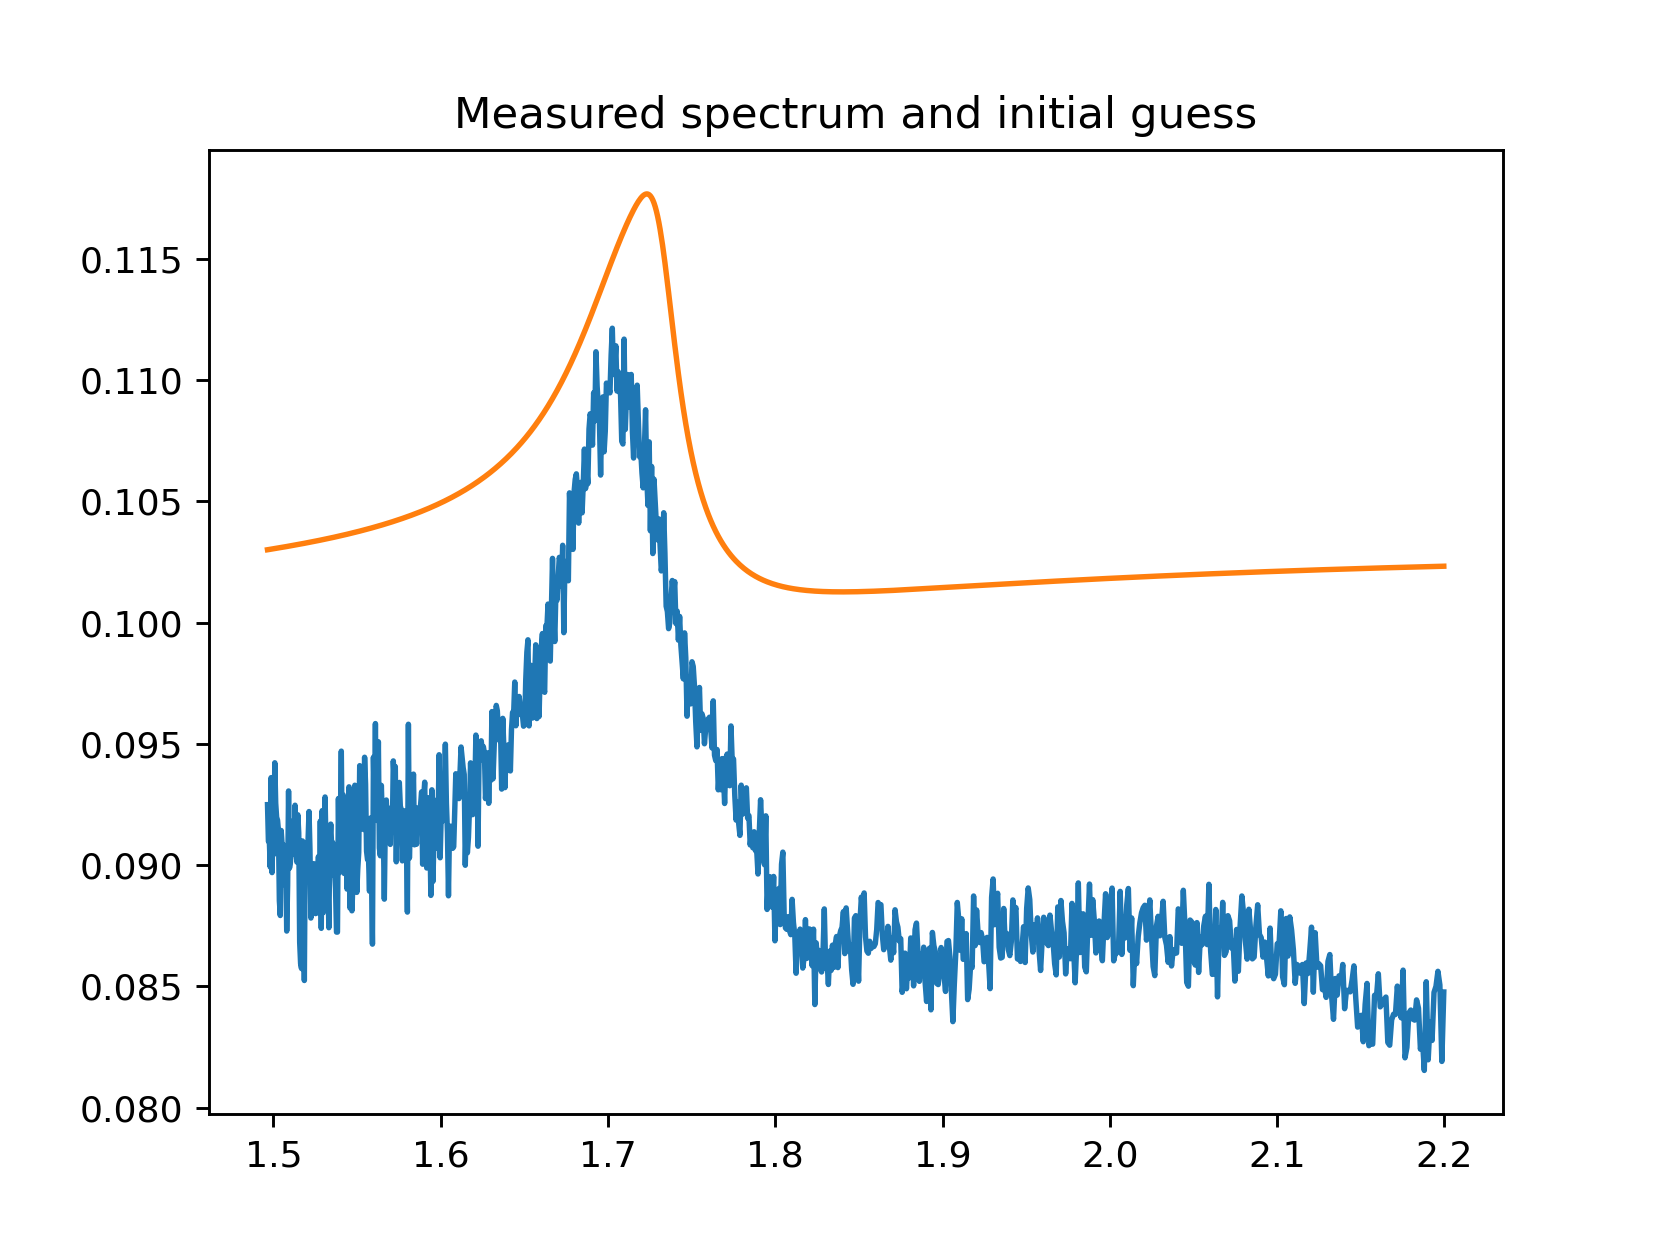

In [14]:
%matplotlib notebook
model = tmm_model(Parameters(), filtered_dat, energies)
model.add_lorentzian('pk1', model.energies,
                    [0.26885770, True, 0, np.inf],
                    [1.72186643, True, 0, 2],
                    [0.08191602, True, 0.05, 0.25])
model.add_lorentzian('pk2', model.energies,
                    [0.06885770, True, 0, np.inf],
                    [1.73186643, True, 1.72186643, 1.85],
                    [0.03191602, True, 0.02, 0.25])

########## Add layers for TMM calculation
model.add_layer('air',    [np.inf, False, 0, np.inf], [1, False, 0, np.inf, None])
model.add_layer('tophbnfull',   [10.87, False, 9, 15],      [2, False, 0, 5.3, None, None])
model.add_layer('sample', [0.3, False, 0.1, 2.7],     [1, True, 0, np.inf, None, None])
model.add_layer('bottomhbnfull',   [13.5, False, 10, 25],      [2, False, 0, 5.3, None, None])
model.add_layer('Grfull',   [1.96, False, 0.3, 2.1],    [1, False, 0, np.inf])
model.add_layer('quartz', [np.inf, False, 0, np.inf], [1.455, False, 1.440, 1.459, None, None])
#### Background dielectric function (not including the +1 for epsilon(inf))
model.params.add('eps_sample_r', 0, False, 2.0, 7)
model.params.add('eps_sample_r_slope', 0, False, -np.inf, np.inf)
model.params.add('eps_sample_i', 0, False, -0.5, 0)
model.params.add('eps_sample_i_slope', 0, False, -np.inf, np.inf)
#### Artifically add a linear background to the RC, could also fit to derivative
model.params.add('offset', 0.1, True, -np.inf, np.inf)
model.params.add('slope', 0, True, -np.inf, np.inf)

model.params.pretty_print()
plt.close('all')
plt.figure()
plt.plot(model.energies, model.data)
plt.plot(model.energies, model.calc_rc())
plt.title('Measured spectrum and initial guess');


<IPython.core.display.Javascript object>


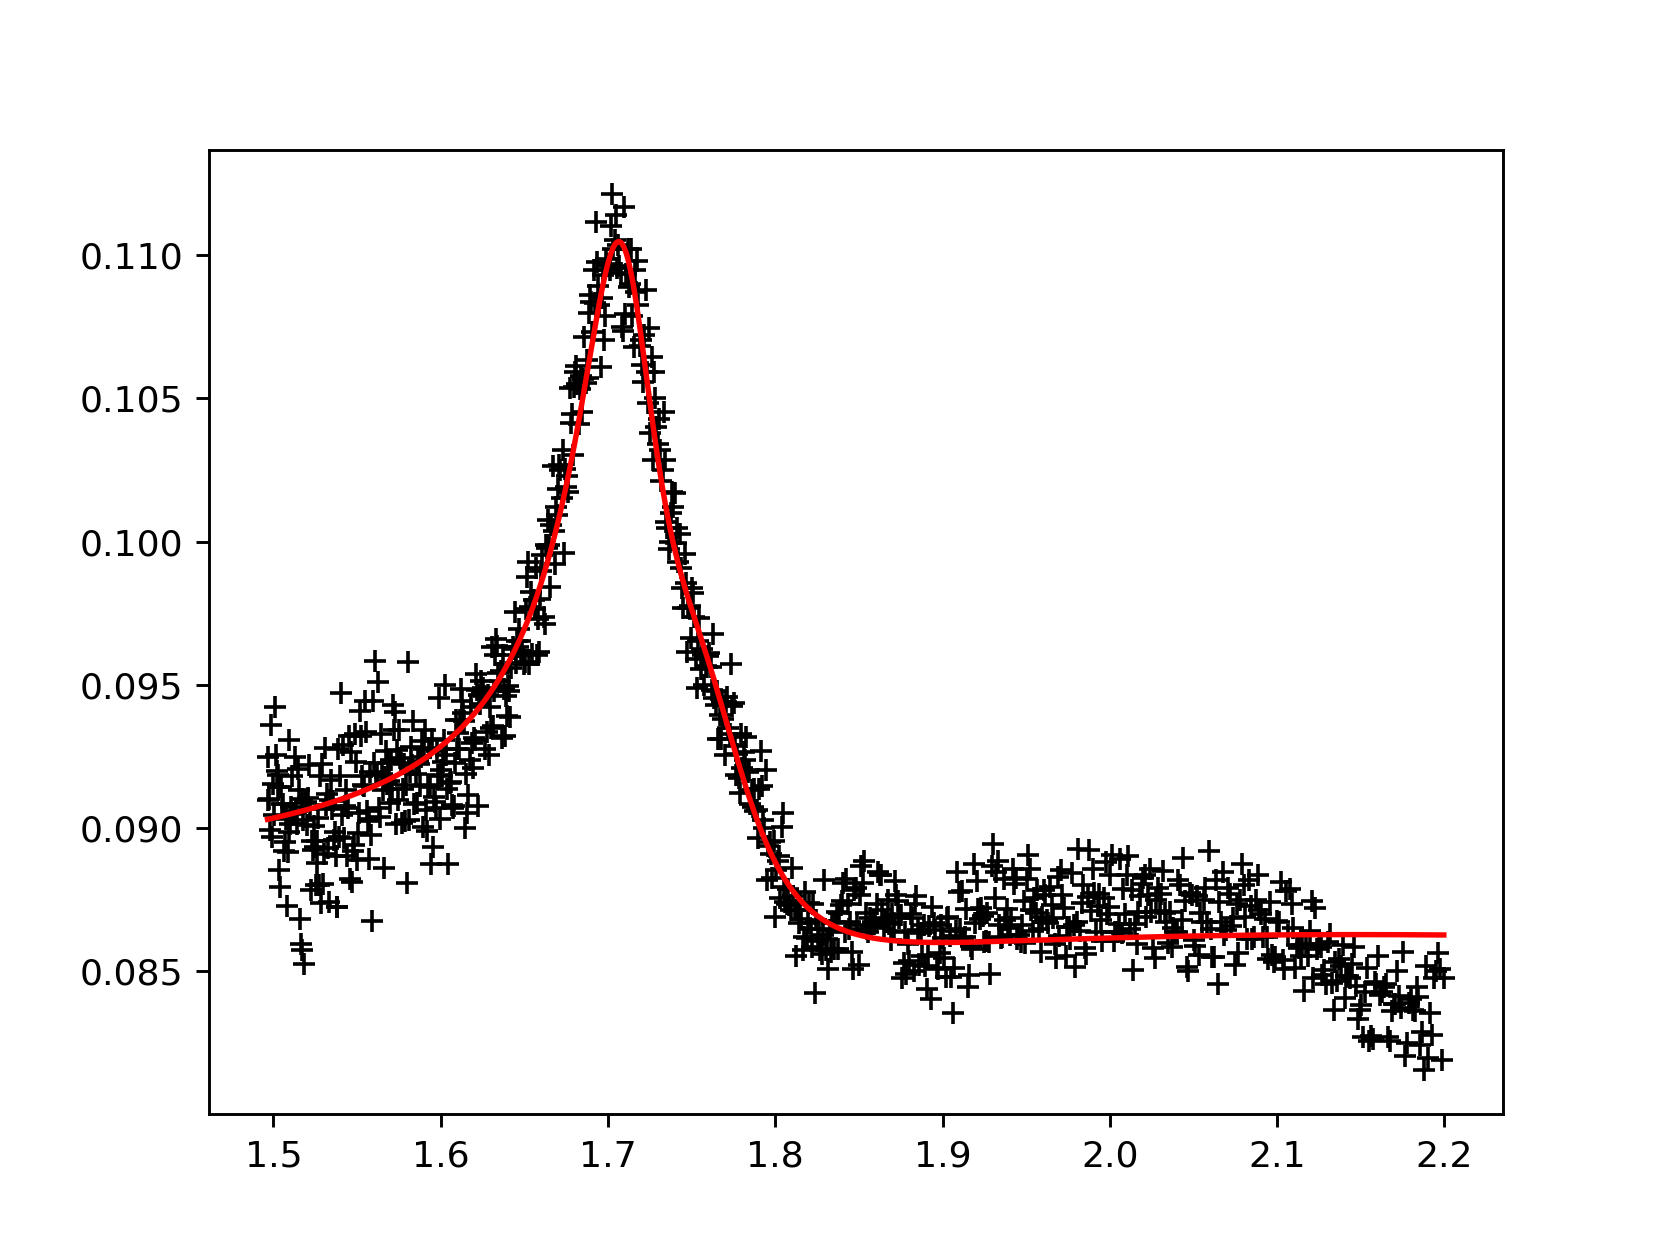

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 346
    # data points      = 883
    # variables        = 9
    chi-square         = 0.00203318
    reduced chi-square = 2.3263e-06
    Akaike info crit   = -11444.6469
    Bayesian info crit = -11401.5970
##  Warning: uncertainties could not be estimated:
    sample_n:            at initial value
[[Variables]]
    pk1_a:               0.31803859 (init = 0.2688577)
    pk1_x0:              1.71250525 (init = 1.721866)
    pk1_w:               0.05776186 (init = 0.08191602)
    pk2_a:               0.24932761 (init = 0.0688577)
    pk2_x0:              1.76145837 (init = 1.731866)
    pk2_w:               0.09226090 (init = 0.03191602)
    air_d:               inf (fixed)
    air_n:               1 (fixed)
    tophbnfull_d:        10.87 (fixed)
    tophbnfull_n:        2 (fixed)
    sample_d:            0.3 (fixed)
    sample_n:            1.00000000 (init = 1)
    bottomhbnfull_d:     13.5 (fixed)
    bottomhb

In [15]:
########################################## Fit RC with initial guesses
model.ls_fit()
plt.close('all')
plt.figure()
plt.plot(model.energies, model.data, 'k+')
plt.plot(model.energies, model.calc_rc(), 'r')
# Report fit results
report_fit(model.result)

In [ ]:
# Building data frame. Run this cell once you are satisfied with the fit
if 'DF' not in globals():
        DF = pd.DataFrame()
else:
        pass
    
# Get labels and values to be appended to dataframe
labels = list(model.params.valuesdict())
values = []
for label in labels:
    values.append(model.params.valuesdict()[label])

df1 = pd.DataFrame(values, columns = [str(filenames[series_id])], index = labels)
DF = pd.concat([DF, df1], axis=1)
DF